# Anomaly Detection in ECG data

This notebook provides tasks to identify anomalies in an ECG data set. Download the dataset from the lab google drive.

Required Python packages: pandas, numpy, matplotlib, pytorch

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader


## Task 1: Load an visualize the data

Download the csv from the link provided above and load it into a pandas dataframe. Visualize the data of normal (label 1) vs abnormal (label 0) ECG signals. 

What are the differences for both? Visualize an average normal and abnormal ECG (with standart derivations).

In [23]:
dataframe = pd.read_csv(
    "http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv", header=None
)
raw_data = dataframe.values

In [24]:
dataframe.shape

(4998, 141)

In [25]:
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [26]:
normal_data: pd.DataFrame = dataframe[dataframe[140]==1]
normal_data.shape

(2919, 141)

In [27]:
anormal_data: pd.DataFrame = dataframe[dataframe[140]==0]
anormal_data.shape

(2079, 141)

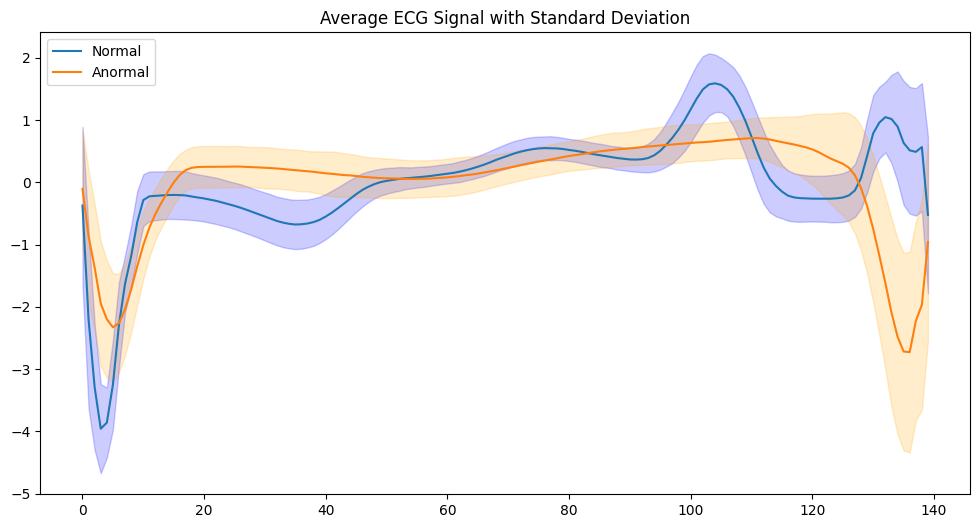

In [28]:
average_normal = normal_data[:-1].mean(axis=0)
average_anormal = anormal_data[:-1].mean(axis=0)

std_normal = normal_data[:-1].std(axis=0)
std_anormal = anormal_data[:-1].std(axis=0)

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(average_normal[:-1], label="Normal")
plt.plot(average_anormal[:-1], label="Anormal")
plt.fill_between(x=range(len(average_normal[:-1])),
                y1=average_normal[:-1]-std_normal[:-1],
                y2=average_normal[:-1]+std_normal[:-1],
                color='blue', alpha=0.2)

plt.fill_between(x=range(len(average_anormal[:-1])),
                y1=average_anormal[:-1]-std_anormal[:-1],
                y2=average_anormal[:-1]+std_anormal[:-1],
                color='orange', alpha=0.2)
plt.title("Average ECG Signal with Standard Deviation")
plt.legend()
plt.show()

In the abnormal data, we can see a large drop in the signal in the end, which is not present in the normal data. Instead, the normal data shows two peaks that do not exist in that form in the abnormal data. Both signals are relatively flat between time point 20 and 100. At the beginning of the signal, both signals show a drop, but the drop in the normal data is more pronounced.

## Task 2: Train a Autoencoder for normal (training data)

Split your data into a (stratified) 80/20 split. Use the normal records of your train data to fit an Autoencoder model. You may use Optuna to find the optimal parametrization of your model.

Visulaize the training/test loss of your model.


In [54]:
# first normalizing the data
# Idea: Split into 80/20 split allows us to train on 80% of the data
# To train, we only use the normal data within the 80% split
# The abnormal data is only used to find the threshold for anomaly detection
# after finding the threshold, we can test the model on the 20% split and see, if the threshold leads to a good classification


y = raw_data[:, -1]
X = raw_data[:, :-1]

print(X.shape)
print(y.shape)

(4998, 140)
(4998,)


In [57]:
train_data, test_data, train_labels, test_labels = train_test_split(
    X, y, test_size=0.2, random_state=42934, stratify=y)

print(f'Mean of training labels: {train_labels.mean()}, mean of test labels: {test_labels.mean()}')

Mean of training labels: 0.5840420210105053, mean of test labels: 0.584


## Training the Auto Encoder:

In [ ]:
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


cpu


In [ ]:
class AE(nn.Module):
    def __init__(self, d_in):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(d_in, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, d_in),
            nn.Tanh()
        )

        def forward(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded
        

In [ ]:
autoencoder_model= AE(d_in = X.shape[1])

loss_fn  = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=1e-3)

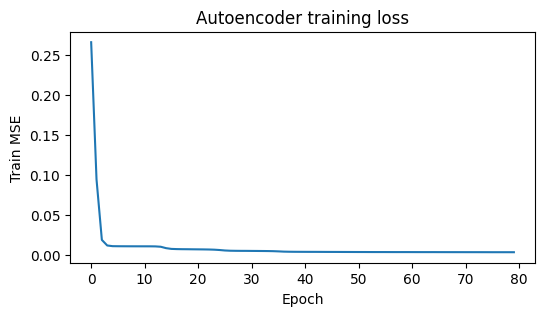

Chosen threshold: 0.008587 (F1 on train-split: 0.968)
TEST ROC-AUC: 0.992 | PR-AUC: 0.978
TEST Precision: 0.945 | Recall: 0.986 | F1: 0.965
Confusion matrix (abnormal=positive):
[[560  24]
 [  6 410]]
TN=560, FP=24, FN=6, TP=410


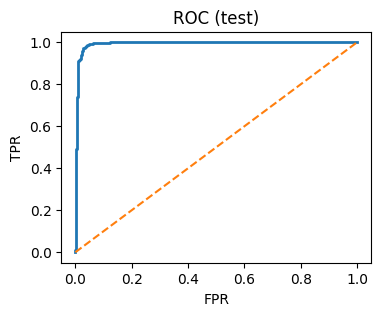

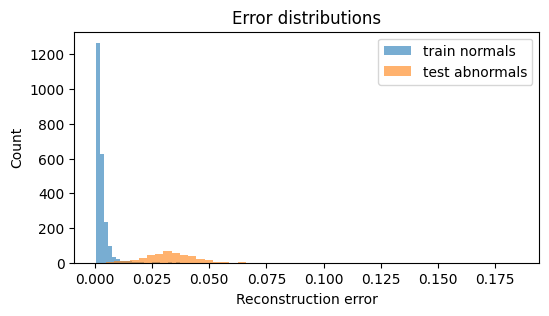

In [58]:
# ==== Setup & scaling (fit scaler ONLY on normal training records) ====
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support, roc_curve

# Reproducibility
def seed_all(seed=42):
    import random, os
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
seed_all(123)

X_train, y_train = train_data, train_labels
X_test,  y_test  = test_data,  test_labels

# train only on normal samples
X_train_norm = X_train[y_train == 1]

scaler = MinMaxScaler()
X_train_norm_sc = scaler.fit_transform(X_train_norm)
X_val_sc        = scaler.transform(X_train)   # contains both normal/abnormal for picking threshold
X_test_sc       = scaler.transform(X_test)

# to tensors
def to_tensor(x): return torch.tensor(x, dtype=torch.float32)
X_train_norm_t = to_tensor(X_train_norm_sc)
X_val_t        = to_tensor(X_val_sc)
X_test_t       = to_tensor(X_test_sc)
y_val_t        = torch.tensor(y_train.astype(np.int64))
y_test_t       = torch.tensor(y_test.astype(np.int64))

# ==== Dataloaders ====
batch_size = 128
train_dl = DataLoader(TensorDataset(X_train_norm_t), batch_size=batch_size, shuffle=True)

# ==== Model ====
in_dim = X_train.shape[1]  # 140
class AE(nn.Module):
    def __init__(self, d_in):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(d_in, 64), nn.ReLU(),
            nn.Linear(64, 16), nn.ReLU(),
            nn.Linear(16, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16), nn.ReLU(),
            nn.Linear(16, 64), nn.ReLU(),
            nn.Linear(64, d_in)
        )
    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AE(in_dim).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# ==== Training loop with simple early stopping on train loss ====
epochs = 80
patience = 10
best_loss, patience_ctr = np.inf, 0
train_losses = []

for ep in range(1, epochs+1):
    model.train()
    epoch_loss = 0.0
    for (xb,) in train_dl:
        xb = xb.to(device)
        optimizer.zero_grad()
        recon = model(xb)
        loss = criterion(recon, xb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(train_dl.dataset)
    train_losses.append(epoch_loss)

    if epoch_loss < best_loss - 1e-5:
        best_loss = epoch_loss
        best_state = {k: v.cpu().clone() for k,v in model.state_dict().items()}
        patience_ctr = 0
    else:
        patience_ctr += 1
    if patience_ctr >= patience:
        break

# load best
model.load_state_dict(best_state)
model.to(device)

# Plot training loss
plt.figure(figsize=(6,3))
plt.plot(train_losses)
plt.xlabel("Epoch"); plt.ylabel("Train MSE"); plt.title("Autoencoder training loss")
plt.show()

# ==== Reconstruction errors ====
@torch.no_grad()
def recon_error(m, x):
    m.eval()
    x = x.to(device)
    r = m(x)
    # per-sample MSE across features
    err = ((r - x)**2).mean(dim=1).cpu().numpy()
    return err

err_train_norm = recon_error(model, X_train_norm_t)     # used to sanity-check distribution
err_val        = recon_error(model, X_val_t)            # choose threshold on train-split (contains both classes)
err_test       = recon_error(model, X_test_t)

# ==== Choose threshold (maximize F1 on the train-split validation) ====
y_val = y_train.astype(int)  # 1=normal, 0=abnormal
# We treat "abnormal" as positive class (1) for metrics below by flipping labels
y_val_pos = (y_val == 0).astype(int)

# Try thresholds on percentiles of validation errors
cand = np.percentile(err_val, np.linspace(50, 99.9, 200))
best_f1, best_thr = -1, None
for t in cand:
    pred_pos = (err_val > t).astype(int)   # positive = abnormal
    _, _, f1, _ = precision_recall_fscore_support(y_val_pos, pred_pos, average='binary', zero_division=0)
    if f1 > best_f1:
        best_f1, best_thr = f1, t

print(f"Chosen threshold: {best_thr:.6f} (F1 on train-split: {best_f1:.3f})")

# ==== Evaluation on TEST split ====
y_test_pos = (y_test == 0).astype(int)       # abnormal = 1
pred_test_pos = (err_test > best_thr).astype(int)

# Metrics
auc_roc = roc_auc_score(y_test_pos, err_test)
auc_pr  = average_precision_score(y_test_pos, err_test)
prec, rec, f1, _ = precision_recall_fscore_support(y_test_pos, pred_test_pos, average='binary', zero_division=0)

print(f"TEST ROC-AUC: {auc_roc:.3f} | PR-AUC: {auc_pr:.3f}")
print(f"TEST Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_pos, pred_test_pos)
tn, fp, fn, tp = cm.ravel()
print("Confusion matrix (abnormal=positive):")
print(cm)
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")

# ROC curve (optional)
fpr, tpr, _ = roc_curve(y_test_pos, err_test)
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (test)")
plt.show()

# Quick sanity plots of error distributions
plt.figure(figsize=(6,3))
plt.hist(err_train_norm, bins=50, alpha=0.6, label="train normals")
plt.hist(err_test[y_test==0], bins=50, alpha=0.6, label="test abnormals")
plt.xlabel("Reconstruction error"); plt.ylabel("Count"); plt.legend(); plt.title("Error distributions")
plt.show()


## Task 3: Treshold your test data & evaluate your model

For any single normal and abnormal test data point, plot the time series, the decoded autoencoder reconstruction and the error as the area between these 2 plots. Compute the absolute error as the absolute of the integral of both graphs.

Plot a histogram of the training/test loss and - based on your findings - generate a treshold to differentiate between normal/anormal test data samples. Based on your predictions, report the performance of your model. 


